<a href="https://colab.research.google.com/github/sandeepgitam/GitHub_Tutorial_GITAM/blob/main/LSK_SWT_CNN_GWO_indian_pines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.io as sio
import sklearn as sk
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from spectral import *

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from NiaPy.algorithms.basic import GreyWolfOptimizer
from NiaPy.algorithms.modified import HybridBatAlgorithm
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import neighbors
from keras.models import load_model

from sklearn.svm import SVC

from sklearn.datasets import make_classification

from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install Niapy
!pip install spectral

In [ ]:
hsi_data=sio.loadmat('/content/Indian_pines_corrected.mat')
indian_pines_data=hsi_data["indian_pines_corrected"]
dim=indian_pines_data.shape
print(dim)

(145, 145, 200)


In [ ]:
hsi_gt=sio.loadmat("/content/Indian_pines_gt.mat")
hsi_gt_arr=hsi_gt['indian_pines_gt']
y=np.reshape(hsi_gt_arr,(dim[0]*dim[1],1))
print(y.shape)
print(np.unique(y))

(21025, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [ ]:
twoD_dim=(dim[0]*dim[1],dim[2])
twoD_hsi_data=np.zeros(twoD_dim)
k=0;
for i in range(0,dim[0]):
  for j in range(0,dim[1]):
    twoD_hsi_data[k,:]=indian_pines_data[i,j,:]
    k=k+1
    
print(twoD_hsi_data.shape)

(21025, 200)


In [ ]:
db1=pywt.Wavelet('db1')
s=(twoD_dim[0],4*twoD_dim[1])
coefsi=np.zeros(s)
db1=pywt.Wavelet('db1')
for i in range(0,twoD_dim[0]):
  temp=pywt.swt(twoD_hsi_data[i,:],db1,level=2,axis=-1)
  coefsi[i,:]=np.ndarray.flatten(np.array(temp))
  
print(np.array(coefsi).shape)

(21025, 800)


In [ ]:
s=(145,145,800)
Coefsi_3d_data=np.zeros(s)
for i in range(0,800):
  Coefsi_3d_data[:,:,i]=np.reshape(coefsi[:,i],(145,145))

In [ ]:
Coefsi_3d_data.shape

(145, 145, 800)

In [ ]:
sio.savemat("Coefsi_3d_data.mat",{"coefsi_3d_data":Coefsi_3d_data})

In [ ]:
def loadIndianPinesData():

    data = sio.loadmat(os.path.join(
                      'Coefsi_3d_data.mat'))['coefsi_3d_data']
    labels = sio.loadmat(os.path.join(
                        'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels

In [ ]:
#  split data to Train and Test Set
def splitTrainTestSet(X, y, classnum=15, testRatio=0.50):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                test_size=testRatio, random_state=345, stratify=y)
    ss=StratifiedShuffleSplit(n_splits=classnum, test_size=testRatio, 
                              train_size=1-testRatio, random_state=0)
    
    for train_index, test_index in ss.split(X, y):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    return X_train, X_test, y_train, y_test

In [ ]:
#  over sample 
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    print(uniqueLabels)
    print("")
    print(labelCounts)
    print("")
    print(maxCount)
    print(labelInverseRatios)

    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), 
                                                   axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        print(label,round(labelInverseRatio))
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))

    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    
    return newX, newY

In [ ]:
def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler

In [ ]:
#  apply PCA preprocessing for data sets
def applyPCA(X, numComponents=100):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
#  pad zeros to dataset
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, 
                     X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + 
         y_offset, :] = X
    return newX

In [ ]:
#  create Patches for dataset
def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, 
                            windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - 
                                margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
#  Augment Data
def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, 
                            no,axes=(1, 0), reshape=False, output=None, 
                            order=3, mode='constant', cval=0.0, prefilter=False)
        
        patch2 = flipped_patch
        X_train[i,:,:,:] = patch2
        

    return X_train

In [ ]:
def savePreprocessedData(path, X_trainPatches, X_testPatches, y_trainPatches, 
                         y_testPatches, windowSize, wasPCAapplied = False, 
                         numPCAComponents = 0, testRatio = 0.25):
    
    

    if wasPCAapplied:
        with open(os.path.join("XtrainWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open(os.path.join( "XtestWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open(os.path.join( "ytrainWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open(os.path.join("ytestWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
    else:
        with open(os.path.join("preXtrainWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open(os.path.join( "preXtestWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open(os.path.join( "preytrainWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open(os.path.join( "preytestWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)

In [ ]:
# Global Variables
# The number of principal components to be retained in the PCA algorithm, 
# the number of retained features  n
numComponents = 5
# Patches windows size
windowSize = 15
# The proportion of Test sets
testRatio = 0.80

In [ ]:
import os
# Load dataset from file and apply PCA
#X, y = loadHSIData()
X,y = loadIndianPinesData()
X, pca = applyPCA(X, numComponents=numComponents)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage
from spectral import *

In [ ]:
# ground_truth = plt.imshow(classes=y, figsize=(10, 10))

In [ ]:
# Preprocess Data
XPatches, yPatches = createPatches(X, y, windowSize=windowSize)
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, 
                                                     y.max()-y.min(), testRatio)

x_train=X_train
print("patch_size :", len(XPatches))
print("Training data 2d array size",len(X_train))
print("Testing data 2d array size",len(X_test))
X_train, y_train = oversampleWeakClasses(X_train, y_train)
print("oversampling 2d array size :",len(X_train))
X_train = AugmentData(X_train)
print("Size of augmentation done :",len(X_train)-len(x_train))
print("Total size of training data with augmented data :",len(X_train))

TRAIN: [6332 8993 5921 ... 3119 9645 3876] TEST: [4830 1536 3039 ... 4407 9112 7370]
TRAIN: [2791 3463 5005 ... 7017 6387 5558] TEST: [9530 2005 9359 ... 8733 5264 2779]
TRAIN: [3632 7529  500 ... 2218 4567 9926] TEST: [9080 4674 1893 ... 8498 2526 7778]
TRAIN: [9947  620 6406 ... 9212 4673 4215] TEST: [1965 4574 4168 ...  935 8962 4866]
TRAIN: [8947 6773 9668 ... 5583 1752 3145] TEST: [1368 5598 4705 ... 7294 5477 5611]
TRAIN: [4364 1232 6332 ... 6865 2601 6687] TEST: [6712 7546 2522 ... 2772 2780 5801]
TRAIN: [7279 3052  832 ... 9190 7242 4404] TEST: [ 300 2367 2350 ... 4161 6664 5670]
TRAIN: [1205 7387  889 ...  315 2707 6865] TEST: [5054 3494 3938 ... 4993 2598 8716]
TRAIN: [ 705 3664 1510 ...  234 6636 2014] TEST: [ 531 5445  552 ... 9862 4699 4633]
TRAIN: [7996 8268 4831 ... 4868 6147 7181] TEST: [2186 9528 3202 ... 7488  712 6310]
TRAIN: [4474 5596 3911 ... 3962 3229 3785] TEST: [ 2062 10032  7405 ... 10133   814  2218]
TRAIN: [4200 8096 4124 ... 1676 9374  103] TEST: [5319 8176

In [ ]:
# save Preprocessed Data to file
savePreprocessedData('predata', X_train, X_test, y_train, y_test, windowSize = windowSize, 
                     wasPCAapplied=True, numPCAComponents = numComponents, 
                     testRatio = testRatio)

In [ ]:
import numpy as np
import scipy
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils
from keras.layers import LeakyReLU
#from sklearn.cross_validation import StratifiedKFold

In [ ]:
# Global Variables
# The number of principal components to be retained in the PCA algorithm, 
# the number of retained features  n
numPCAcomponents = 5
# Patches windows size
windowSize = 15
# The proportion of Test sets
testRatio = 0.80

In [ ]:
# load Preprocessed data from file
X_train = np.load("XtrainWindowSize" 
                  + str(windowSize) + "PCA" + str(numPCAcomponents) + 
                  "testRatio" + str(testRatio)  + ".npy")
y_train = np.load("ytrainWindowSize" 
                  + str(windowSize) + "PCA" + str(numPCAcomponents) + 
                  "testRatio" + str(testRatio) + ".npy")
X_test = np.load("XtestWindowSize" 
                  + str(windowSize) + "PCA" + str(numPCAcomponents) + 
                 "testRatio" + str(testRatio)  + ".npy")
y_test = np.load("ytestWindowSize" 
                  + str(windowSize) + "PCA" + str(numPCAcomponents) + 
                 "testRatio" + str(testRatio) + ".npy")

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[3], 
                               X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[3], 
                             X_test.shape[1], X_test.shape[2]))

# convert class labels to on-hot encoding
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# Define the input shape 
input_shape= X_train[0].shape
print(input_shape)

# number of filters
C1 = 3*numPCAcomponents

(5, 15, 15)


In [ ]:
activation_cnn_layer = [
    'relu',
    'tanh']

activation_feed_layer = [
    'relu',
    'tanh']


optimizers=["adam",'sgd']

# map from real number [0, 1] to integer ranging [1, 3]
def swap_activation_cnn(val):
    if val == 1:
        return 2
    return int(val * 2 + 1)

def swap_activation_feed(val):
    if val == 1:
        return 2
    return int(val * 2 + 1)

def swap_optimzer(val):
    if val == 1:
        return 2
    return int(val * 2 + 1)


def no_of_epoch(val):
  return int(50)


# map from real number [0, 1] to integer ranging [5, 15]
def no_of_batch(val):
    return int(val *224 + 32)

def no_of_filters(val):
  return int(val*8 + 1)

def no_neurons_hidden_layer(val):
  return int(val*64+8)

def kernel_size(val):
  return int(val*1+10)
def dropout(val):
  return int(val*1+0.1)

class cnnbenchmark():
  def __init__(self):
        self.Lower = 0
        self.Upper = 1
  def function(self):
      # our definition of fitness function
      def evaluate(D, solution):
          acc_cnn_layer = activation_cnn_layer[swap_activation_cnn(solution[0]-1)]
          print(acc_cnn_layer)
          acc_feed_layer = activation_feed_layer[swap_activation_feed((solution[1]) - 1)]
          optimizer = optimizers[(swap_optimzer(solution[2])- 1)]
          epochs = no_of_epoch(solution[3])
          batch=no_of_batch(solution[4])
          filters=no_of_filters(solution[5])
          neurons=no_neurons_hidden_layer(solution[6])
          kernel_s=kernel_size(solution[7])
          drop_neurons=dropout(solution[8])
          
          accuracy = 1 - model.model_build(acc_cnn_layer,acc_feed_layer,optimizer,epochs,batch,filters,neurons,kernel_s,drop_neurons)
          scores.append([accuracy,acc_cnn_layer,acc_feed_layer,optimizer,epochs,batch,filters,neurons,kernel_s,drop_neurons])
          return accuracy
      return evaluate

In [ ]:
class model():
  def model_build(acc_cnn_layer,acc_feed_layer,
                  optimizer,epochs,batch,filters,neurons,kernel_s,drop_neurons):
    print("Activation cnn layer :",acc_cnn_layer)
    print("Activation feed layer :",acc_feed_layer)
    print("optimizer :",optimizer)
    print("batch :",batch)
    print("epochs :",epochs)
    print("dropout :",drop_neurons)
    print("no of filters :",filters)
    model = Sequential()
    model.add(Conv2D(64, (3,3), activation=acc_cnn_layer, input_shape=input_shape))
    model.add(Conv2D(128, (3,3), activation=acc_cnn_layer))
    model.add(Dropout(drop_neurons))
    model.add(Flatten())
    model.add(Dense(6*numPCAcomponents, activation=acc_feed_layer))
    model.add(Dropout(drop_neurons))
    model.add(Dense(16, activation='softmax'))

    # Define optimization and train method
    reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, 
                                  min_lr=0.000001, verbose=1)
    checkpointer = ModelCheckpoint(filepath="checkpoint.hdf5", verbose=1, 
                                  save_best_only=False)
    # sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
                                  metrics=['accuracy'])
    # Start to train model 
    history = model.fit(X_train, y_train, 
                        batch_size=batch, 
                        epochs=100, 
                        verbose=1, 
                        validation_data=(X_test, y_test),
                        callbacks=[reduce_lr, checkpointer],
                        shuffle=True)
    
    model.save('HSI_model_epochs100.h5')
    model = load_model('HSI_model_epochs100.h5')
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss = score[0]*100
    Test_accuracy = score[1]*100

    return Test_accuracy

In [ ]:
scores = []
algorithm = GreyWolfOptimizer(9, 40, 100,cnnbenchmark())
best = algorithm.run()

print('Optimal CNN model parameters are:')
best_solution = []

for score in scores:
    if score[0] == best:
        best_solution = score

print(best_solution)


Epoch 00036: saving model to checkpoint.hdf5
Epoch 37/100
52/52 [==============================] - 0s 6ms/step - loss: 0.1415 - accuracy: 0.9647 - val_loss: 0.3968 - val_accuracy: 0.8693



Epoch 00037: saving model to checkpoint.hdf5
Epoch 38/100
52/52 [==============================] - 0s 7ms/step - loss: 0.1293 - accuracy: 0.9672 - val_loss: 0.3389 - val_accuracy: 0.8809



Epoch 00038: saving model to checkpoint.hdf5
Epoch 39/100
52/52 [==============================] - 0s 6ms/step - loss: 0.1290 - accuracy: 0.9654 - val_loss: 0.3396 - val_accuracy: 0.8824



Epoch 00039: saving model to checkpoint.hdf5
Epoch 40/100
52/52 [==============================] - 0s 6ms/step - loss: 0.1210 - accuracy: 0.9677 - val_loss: 0.2743 - val_accuracy: 0.9182



Epoch 00040: saving model to checkpoint.hdf5
Epoch 41/100
52/52 [==============================] - 0s 6ms/step - loss: 0.1159 - accuracy: 0.9696 - val_loss: 0.2666 - val_accuracy: 0.9194



Epoch 00041: saving model to checkpoint.hdf5
Epoch 42/100
52/52 [==============================] - 0s 6ms/step - loss: 0.1194 - accuracy: 0.9704 - val_loss: 0.2830 - val_accuracy: 0.9100



Epoch 00042: saving model to checkpoint.hdf5
Epoch 43/100
52/52 [==============================] - 0s 7ms/step - loss: 0.1141 - accuracy: 0.9690 - val_loss: 0.2894 - val_accuracy: 0.9066



Epoch 00043: saving model to checkpoint.hdf5
Epoch 44/100
52/52 [==============================] - 0s 6ms/step - loss: 0.1085 - accuracy: 0.9708 - val_loss: 0.2846 - val_accuracy: 0.9077



Epoch 00044: saving model to checkpoint.hdf5
Epoch 45/100
52/52 [==============================] - 0s 6ms/step - loss: 0.1033 - accuracy: 0.9742 - val_loss: 0.2782 - val_accuracy: 0.9100



Epoch 00045: saving model to checkpoint.hdf5
Epoch 46/100
52/52 [==============================] - 0s 8ms/step - loss: 0.1018 - accuracy: 0.9758 - val_loss: 0.2886 - val_accuracy: 0.8961



Epoch 00046: saving model to checkpoint.hdf5
Epoch 47/100
52/52 [==============================] - 0s 7ms/step - loss: 0.0933 - accuracy: 0.9789 - val_loss: 0.2375 - val_accuracy: 0.9271



Epoch 00047: saving model to checkpoint.hdf5
Epoch 48/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0941 - accuracy: 0.9785 - val_loss: 0.2628 - val_accuracy: 0.9138



Epoch 00048: saving model to checkpoint.hdf5
Epoch 49/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0874 - accuracy: 0.9797 - val_loss: 0.2368 - val_accuracy: 0.9257



Epoch 00049: saving model to checkpoint.hdf5
Epoch 50/100
52/52 [==============================] - 0s 7ms/step - loss: 0.0864 - accuracy: 0.9789 - val_loss: 0.2404 - val_accuracy: 0.9259



Epoch 00050: saving model to checkpoint.hdf5
Epoch 51/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0870 - accuracy: 0.9790 - val_loss: 0.2766 - val_accuracy: 0.9085



Epoch 00051: saving model to checkpoint.hdf5
Epoch 52/100
52/52 [==============================] - 0s 7ms/step - loss: 0.0847 - accuracy: 0.9799 - val_loss: 0.2070 - val_accuracy: 0.9371



Epoch 00052: saving model to checkpoint.hdf5
Epoch 53/100
52/52 [==============================] - 0s 7ms/step - loss: 0.0835 - accuracy: 0.9789 - val_loss: 0.2234 - val_accuracy: 0.9274



Epoch 00053: saving model to checkpoint.hdf5
Epoch 54/100
52/52 [==============================] - 0s 7ms/step - loss: 0.0782 - accuracy: 0.9824 - val_loss: 0.2416 - val_accuracy: 0.9234



Epoch 00054: saving model to checkpoint.hdf5
Epoch 55/100
52/52 [==============================] - 0s 9ms/step - loss: 0.0725 - accuracy: 0.9851 - val_loss: 0.2560 - val_accuracy: 0.9150



Epoch 00055: saving model to checkpoint.hdf5
Epoch 56/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0729 - accuracy: 0.9843 - val_loss: 0.2006 - val_accuracy: 0.9396



Epoch 00056: saving model to checkpoint.hdf5
Epoch 57/100
52/52 [==============================] - 0s 7ms/step - loss: 0.0675 - accuracy: 0.9864 - val_loss: 0.2122 - val_accuracy: 0.9352



Epoch 00057: saving model to checkpoint.hdf5
Epoch 58/100
52/52 [==============================] - 0s 7ms/step - loss: 0.0670 - accuracy: 0.9870 - val_loss: 0.2097 - val_accuracy: 0.9371



Epoch 00058: saving model to checkpoint.hdf5
Epoch 59/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0694 - accuracy: 0.9849 - val_loss: 0.1972 - val_accuracy: 0.9383



Epoch 00059: saving model to checkpoint.hdf5
Epoch 60/100
52/52 [==============================] - 0s 7ms/step - loss: 0.0652 - accuracy: 0.9865 - val_loss: 0.2024 - val_accuracy: 0.9349



Epoch 00060: saving model to checkpoint.hdf5
Epoch 61/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0630 - accuracy: 0.9876 - val_loss: 0.2103 - val_accuracy: 0.9316



Epoch 00061: saving model to checkpoint.hdf5
Epoch 62/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0657 - accuracy: 0.9833 - val_loss: 0.2040 - val_accuracy: 0.9346



Epoch 00062: saving model to checkpoint.hdf5
Epoch 63/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0604 - accuracy: 0.9870 - val_loss: 0.2334 - val_accuracy: 0.9183



Epoch 00063: saving model to checkpoint.hdf5
Epoch 64/100
48/52 [==========================>...] - ETA: 0s - loss: 0.0583 - accuracy: 0.9869

KeyboardInterrupt: ignored

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
# Define the model structure
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(128, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(6*numPCAcomponents, activation='relu'))
model.add(Dense(16, activation='softmax'))

In [ ]:
# Define optimization and train method
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, 
                              min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="checkpoint.hdf5", verbose=1, 
                              save_best_only=False)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer="adam", 
                              metrics=['accuracy'])

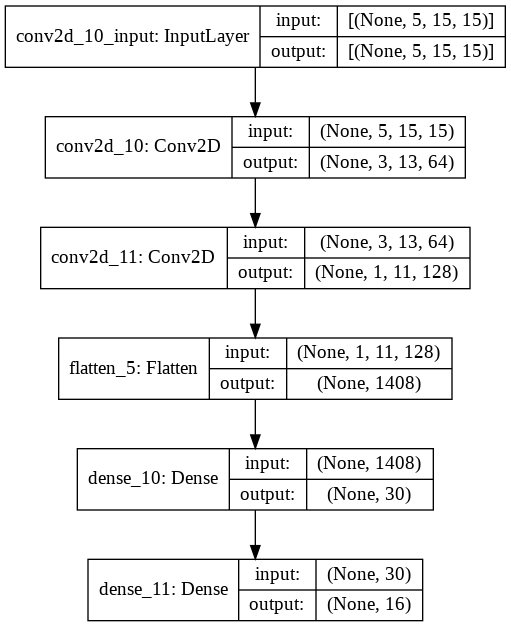

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Start to train model 
history = model.fit(X_train, y_train, 
                    batch_size=210, 
                    epochs=50, 
                    verbose=1, 
                    validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, checkpointer],
                    shuffle=True)

Epoch 1/50
38/38 [==============================] - 1s 12ms/step - loss: 1.9698 - accuracy: 0.3699 - val_loss: 0.9639 - val_accuracy: 0.6900



Epoch 00001: saving model to checkpoint.hdf5
Epoch 2/50
38/38 [==============================] - 0s 7ms/step - loss: 0.5685 - accuracy: 0.8075 - val_loss: 0.6949 - val_accuracy: 0.7939



Epoch 00002: saving model to checkpoint.hdf5
Epoch 3/50
38/38 [==============================] - 0s 7ms/step - loss: 0.3112 - accuracy: 0.9029 - val_loss: 0.3778 - val_accuracy: 0.8838



Epoch 00003: saving model to checkpoint.hdf5
Epoch 4/50
38/38 [==============================] - 0s 7ms/step - loss: 0.2094 - accuracy: 0.9325 - val_loss: 0.3258 - val_accuracy: 0.8894



Epoch 00004: saving model to checkpoint.hdf5
Epoch 5/50
38/38 [==============================] - 0s 7ms/step - loss: 0.1365 - accuracy: 0.9597 - val_loss: 0.2395 - val_accuracy: 0.9204



Epoch 00005: saving model to checkpoint.hdf5
Epoch 6/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0939 - accuracy: 0.9747 - val_loss: 0.1972 - val_accuracy: 0.9321



Epoch 00006: saving model to checkpoint.hdf5
Epoch 7/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0634 - accuracy: 0.9855 - val_loss: 0.1658 - val_accuracy: 0.9433



Epoch 00007: saving model to checkpoint.hdf5
Epoch 8/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0452 - accuracy: 0.9906 - val_loss: 0.1877 - val_accuracy: 0.9432



Epoch 00008: saving model to checkpoint.hdf5
Epoch 9/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0403 - accuracy: 0.9920 - val_loss: 0.1731 - val_accuracy: 0.9441



Epoch 00009: saving model to checkpoint.hdf5
Epoch 10/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0345 - accuracy: 0.9916 - val_loss: 0.1071 - val_accuracy: 0.9648



Epoch 00010: saving model to checkpoint.hdf5
Epoch 11/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0211 - accuracy: 0.9964 - val_loss: 0.1186 - val_accuracy: 0.9645



Epoch 00011: saving model to checkpoint.hdf5
Epoch 12/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0151 - accuracy: 0.9975 - val_loss: 0.0917 - val_accuracy: 0.9709



Epoch 00012: saving model to checkpoint.hdf5
Epoch 13/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0080 - accuracy: 0.9997 - val_loss: 0.0971 - val_accuracy: 0.9709



Epoch 00013: saving model to checkpoint.hdf5
Epoch 14/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0908 - val_accuracy: 0.9733



Epoch 00014: saving model to checkpoint.hdf5
Epoch 15/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0061 - accuracy: 0.9997 - val_loss: 0.0929 - val_accuracy: 0.9713



Epoch 00015: saving model to checkpoint.hdf5
Epoch 16/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0054 - accuracy: 0.9999 - val_loss: 0.0956 - val_accuracy: 0.9700



Epoch 00016: saving model to checkpoint.hdf5
Epoch 17/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0040 - accuracy: 0.9999 - val_loss: 0.0938 - val_accuracy: 0.9717



Epoch 00017: saving model to checkpoint.hdf5
Epoch 18/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0799 - val_accuracy: 0.9767



Epoch 00018: saving model to checkpoint.hdf5
Epoch 19/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1042 - val_accuracy: 0.9682



Epoch 00019: saving model to checkpoint.hdf5
Epoch 20/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0875 - val_accuracy: 0.9735



Epoch 00020: saving model to checkpoint.hdf5
Epoch 21/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0876 - val_accuracy: 0.9737



Epoch 00021: saving model to checkpoint.hdf5
Epoch 22/50
38/38 [==============================] - 0s 10ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0894 - val_accuracy: 0.9735



Epoch 00022: saving model to checkpoint.hdf5
Epoch 23/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0896 - val_accuracy: 0.9737



Epoch 00023: saving model to checkpoint.hdf5
Epoch 24/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0885 - val_accuracy: 0.9740



Epoch 00024: saving model to checkpoint.hdf5
Epoch 25/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0922 - val_accuracy: 0.9734



Epoch 00025: saving model to checkpoint.hdf5
Epoch 26/50
38/38 [==============================] - 0s 7ms/step - loss: 9.9741e-04 - accuracy: 1.0000 - val_loss: 0.0925 - val_accuracy: 0.9733



Epoch 00026: saving model to checkpoint.hdf5
Epoch 27/50
38/38 [==============================] - 0s 7ms/step - loss: 9.8215e-04 - accuracy: 1.0000 - val_loss: 0.0902 - val_accuracy: 0.9729



Epoch 00027: saving model to checkpoint.hdf5
Epoch 28/50
38/38 [==============================] - 0s 7ms/step - loss: 8.6925e-04 - accuracy: 1.0000 - val_loss: 0.0875 - val_accuracy: 0.9739



Epoch 00028: saving model to checkpoint.hdf5
Epoch 29/50
38/38 [==============================] - 0s 7ms/step - loss: 8.6255e-04 - accuracy: 1.0000 - val_loss: 0.0922 - val_accuracy: 0.9739



Epoch 00029: saving model to checkpoint.hdf5
Epoch 30/50
38/38 [==============================] - 0s 7ms/step - loss: 8.0744e-04 - accuracy: 1.0000 - val_loss: 0.0875 - val_accuracy: 0.9756



Epoch 00030: saving model to checkpoint.hdf5
Epoch 31/50
38/38 [==============================] - 0s 7ms/step - loss: 7.0799e-04 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9760



Epoch 00031: saving model to checkpoint.hdf5
Epoch 32/50
38/38 [==============================] - 0s 7ms/step - loss: 6.4645e-04 - accuracy: 1.0000 - val_loss: 0.0886 - val_accuracy: 0.9748



Epoch 00032: saving model to checkpoint.hdf5
Epoch 33/50
38/38 [==============================] - 0s 7ms/step - loss: 6.2273e-04 - accuracy: 1.0000 - val_loss: 0.0913 - val_accuracy: 0.9763



Epoch 00033: saving model to checkpoint.hdf5
Epoch 34/50
38/38 [==============================] - 0s 7ms/step - loss: 5.4233e-04 - accuracy: 1.0000 - val_loss: 0.0953 - val_accuracy: 0.9738



Epoch 00034: saving model to checkpoint.hdf5
Epoch 35/50
38/38 [==============================] - 0s 7ms/step - loss: 5.4256e-04 - accuracy: 1.0000 - val_loss: 0.0899 - val_accuracy: 0.9763



Epoch 00035: saving model to checkpoint.hdf5
Epoch 36/50
38/38 [==============================] - 0s 7ms/step - loss: 5.0122e-04 - accuracy: 1.0000 - val_loss: 0.0907 - val_accuracy: 0.9739



Epoch 00036: saving model to checkpoint.hdf5
Epoch 37/50
38/38 [==============================] - 0s 7ms/step - loss: 4.8440e-04 - accuracy: 1.0000 - val_loss: 0.0913 - val_accuracy: 0.9744



Epoch 00037: saving model to checkpoint.hdf5
Epoch 38/50
38/38 [==============================] - 0s 7ms/step - loss: 4.4328e-04 - accuracy: 1.0000 - val_loss: 0.0918 - val_accuracy: 0.9765



Epoch 00038: saving model to checkpoint.hdf5
Epoch 39/50
38/38 [==============================] - 0s 7ms/step - loss: 4.1748e-04 - accuracy: 1.0000 - val_loss: 0.0937 - val_accuracy: 0.9759



Epoch 00039: saving model to checkpoint.hdf5
Epoch 40/50
38/38 [==============================] - 0s 7ms/step - loss: 3.9312e-04 - accuracy: 1.0000 - val_loss: 0.0903 - val_accuracy: 0.9760



Epoch 00040: saving model to checkpoint.hdf5
Epoch 41/50
38/38 [==============================] - 0s 7ms/step - loss: 3.4586e-04 - accuracy: 1.0000 - val_loss: 0.0957 - val_accuracy: 0.9745



Epoch 00041: saving model to checkpoint.hdf5
Epoch 42/50
38/38 [==============================] - 0s 7ms/step - loss: 3.7767e-04 - accuracy: 1.0000 - val_loss: 0.0933 - val_accuracy: 0.9750



Epoch 00042: saving model to checkpoint.hdf5
Epoch 43/50
38/38 [==============================] - 0s 7ms/step - loss: 3.3120e-04 - accuracy: 1.0000 - val_loss: 0.0940 - val_accuracy: 0.9744



Epoch 00043: saving model to checkpoint.hdf5
Epoch 44/50
38/38 [==============================] - 0s 7ms/step - loss: 2.9861e-04 - accuracy: 1.0000 - val_loss: 0.0931 - val_accuracy: 0.9746



Epoch 00044: saving model to checkpoint.hdf5
Epoch 45/50
38/38 [==============================] - 0s 7ms/step - loss: 3.0659e-04 - accuracy: 1.0000 - val_loss: 0.0937 - val_accuracy: 0.9762



Epoch 00045: saving model to checkpoint.hdf5
Epoch 46/50
38/38 [==============================] - 0s 7ms/step - loss: 2.9478e-04 - accuracy: 1.0000 - val_loss: 0.0926 - val_accuracy: 0.9766



Epoch 00046: saving model to checkpoint.hdf5
Epoch 47/50
38/38 [==============================] - 0s 7ms/step - loss: 2.6960e-04 - accuracy: 1.0000 - val_loss: 0.0957 - val_accuracy: 0.9755



Epoch 00047: saving model to checkpoint.hdf5
Epoch 48/50
38/38 [==============================] - 0s 7ms/step - loss: 2.5735e-04 - accuracy: 1.0000 - val_loss: 0.0979 - val_accuracy: 0.9750



Epoch 00048: saving model to checkpoint.hdf5
Epoch 49/50
38/38 [==============================] - 0s 7ms/step - loss: 2.3092e-04 - accuracy: 1.0000 - val_loss: 0.0950 - val_accuracy: 0.9745



Epoch 00049: saving model to checkpoint.hdf5
Epoch 50/50
38/38 [==============================] - 0s 7ms/step - loss: 2.1892e-04 - accuracy: 1.0000 - val_loss: 0.0952 - val_accuracy: 0.9759



Epoch 00050: saving model to checkpoint.hdf5


In [ ]:
# save the model with h5py
import h5py
from keras.models import load_model
model.save('HSI_model_epochs100.h5')

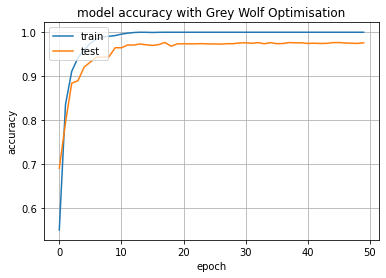

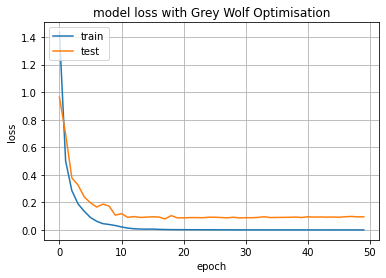

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy with Grey Wolf Optimisation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left') 
plt.savefig("model_accuracy_100.svg")
plt.show()

# summarize history for loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with Grey Wolf Optimisation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left') 
plt.savefig("model_loss_100.svg")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
# Get the model evaluation report, 
# include classification report, confusion matrix, Test_Loss, Test_accuracy
target_names = ['Alfala', 'Corn-notil', 'Corn-mintil', 'Corn'
           ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
            'Hay-windrowed', 'Oats',"Soyabean-notill","Soyabean-mintill","Soyabean-clean"
            ,"Wheat","Woods","Building-Grass-Trees-Drives","Stone-Steel-Towers"]
def reports(X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss = score[0]
    Test_accuracy = score[1]*100
    kappa = cohen_kappa_score(y_pred,np.argmax(y_test, axis=1))
    print("kappa score  : ",kappa*100)
    
    return classification, confusion, Test_Loss, Test_accuracy

In [ ]:
# load the model architecture and weights
model = load_model('HSI_model_epochs100.h5')

# calculate result, loss, accuray and confusion matrix
classification, confusion, Test_loss, Test_accuracy = reports(X_test,y_test)
classification = str(classification)
confusion_str = str(confusion)

# show result and save to file
print('Test loss {} (%)'.format(Test_loss))
print('Test accuracy {} (%)'.format(Test_accuracy))
print("classification result: ")
print('{}'.format(classification))
print("confusion matrix: ")
print('{}'.format(confusion_str))
file_name ="WindowSize" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) +".txt"
with open(file_name, 'w') as x_file:
    x_file.write('Test loss {} (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('Test accuracy {} (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write(" classification result: \n")
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write(" confusion matrix: \n")
    x_file.write('{}'.format(confusion_str))

257/257 [==============================] - 1s 2ms/step - loss: 0.0952 - accuracy: 0.9759
kappa score  :  97.25036647808577
Test loss 0.09524518996477127 (%)
Test accuracy 97.5853681564331 (%)
classification result: 
                             precision    recall  f1-score   support

                     Alfala       1.00      0.95      0.97        37
                 Corn-notil       0.97      0.96      0.97      1143
                Corn-mintil       0.93      0.95      0.94       664
                       Corn       0.97      0.99      0.98       190
              Grass-pasture       0.98      0.97      0.98       386
                Grass-trees       0.99      0.99      0.99       584
        Grass-pasture-mowed       1.00      1.00      1.00        22
              Hay-windrowed       0.99      1.00      1.00       382
                       Oats       0.89      1.00      0.94        16
            Soyabean-notill       0.96      0.99      0.98       778
           Soyabean-mint

Confusion matrix, without normalization
[[ 19   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 539   6   2   0   0   0   0   0   5  13   6   0   0   0   0]
 [  0   1 324   1   0   0   0   0   0   0   2   2   1   1   0   0]
 [  0   0   0  95   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 192   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   1 286   0   0   0   0   0   0   0   0   5   0]
 [  0   0   0   0   0   0  11   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 191   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   8   0   0   0   0   0   0   0]
 [  0   7   0   2   0   0   0   0   0 375   4   1   0   0   0   0]
 [  0  14   4   1   1   0   0   0   0   7 951   4   0   0   0   0]
 [  0   0   2   0   1   0   0   0   0   3   1 230   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  82   0   0   0]
 [  0   0   0   0   2   0   0   0   0   0   0   0   1 494   9   0]
 [  0   0   0   0   0 

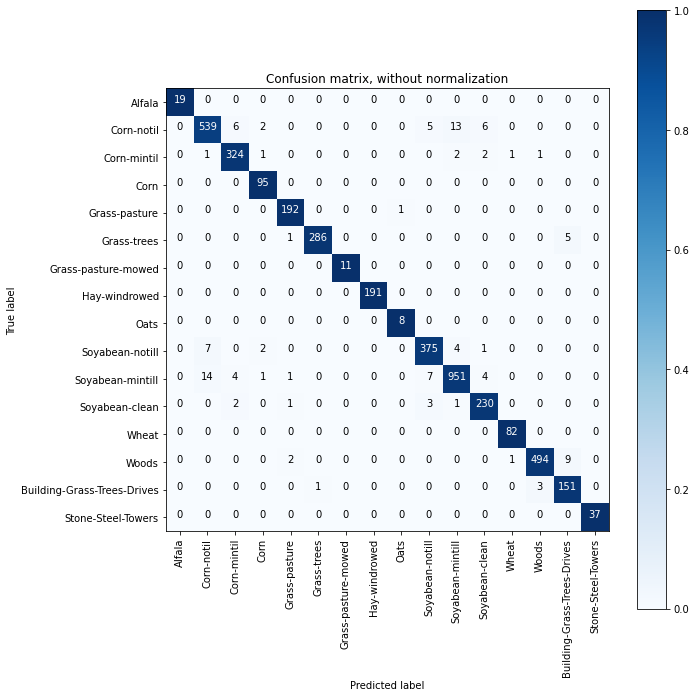

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.94395797 0.01050788 0.00350263 0.         0.
  0.         0.         0.         0.00875657 0.02276708 0.01050788
  0.         0.         0.         0.        ]
 [0.         0.00301205 0.97590361 0.00301205 0.         0.
  0.         0.         0.         0.         0.0060241  0.0060241
  0.00301205 0.00301205 0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.99481865 0.
  0.         0.         0.00518135 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.00342466 0.97945205
  0.         0.         0.         0.         0.      

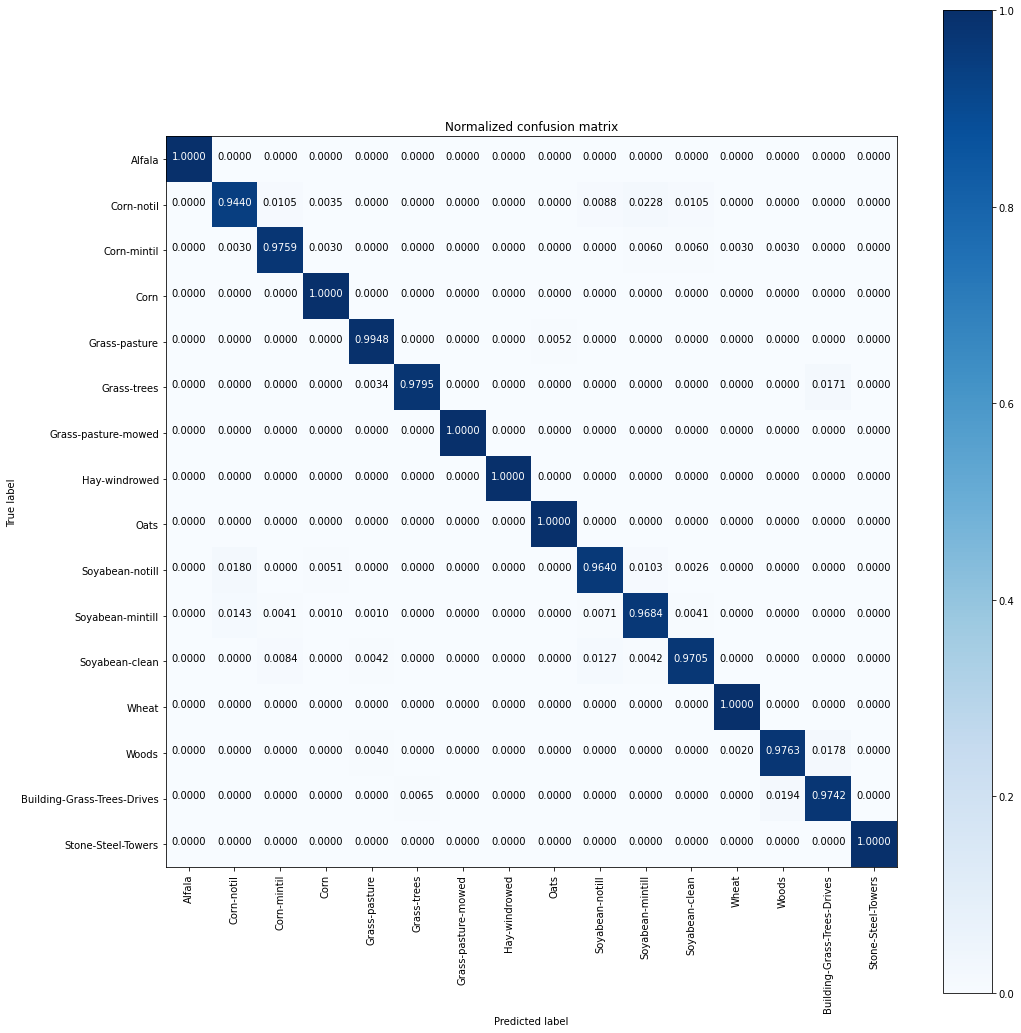

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.get_cmap("Blues")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    Normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if normalize:
        cm = Normalized
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(Normalized, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        thresh = cm[i].max() / 2.
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion, classes=target_names, normalize=False,title='Confusion matrix, without normalization')
plt.savefig("confusion_matrix_without_normalization.svg")
plt.show()
plt.figure(figsize=(15,15))
plot_confusion_matrix(confusion, classes=target_names, normalize=True,title='Normalized confusion matrix')
plt.savefig("confusion_matrix_with_normalization.svg")
plt.show()

In [ ]:
def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
output_image = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

In [ ]:
height =output_image.shape[0]
width = output_image.shape[1]
PATCH_SIZE = 15
numComponents = 5

In [ ]:
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):
    for j in range(width-PATCH_SIZE+1):
        target = int(output_image[i+int(PATCH_SIZE/2), j+int(PATCH_SIZE/2)])
        if target == 0 :
            continue00
        else :
            image_patch=Patch(X,i,j)
            #print (image_patch.shape)
            X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict_classes(X_test_image))                         
            outputs[i+int(PATCH_SIZE/2)][j+int(PATCH_SIZE/2)] = prediction+1

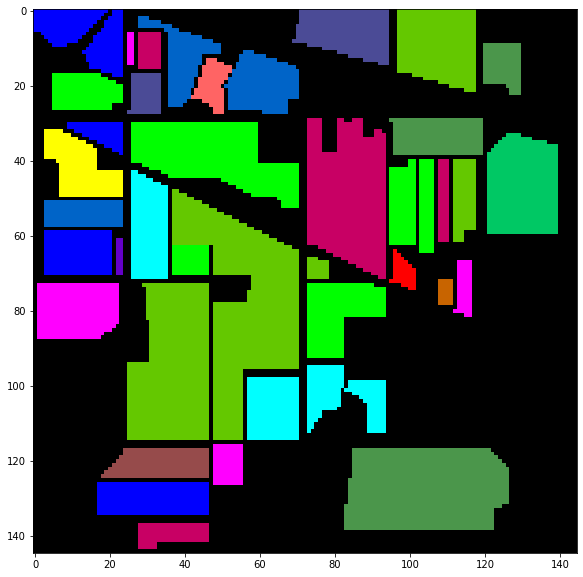

In [ ]:
ground_truth = imshow(classes=y,figsize =(10,10))

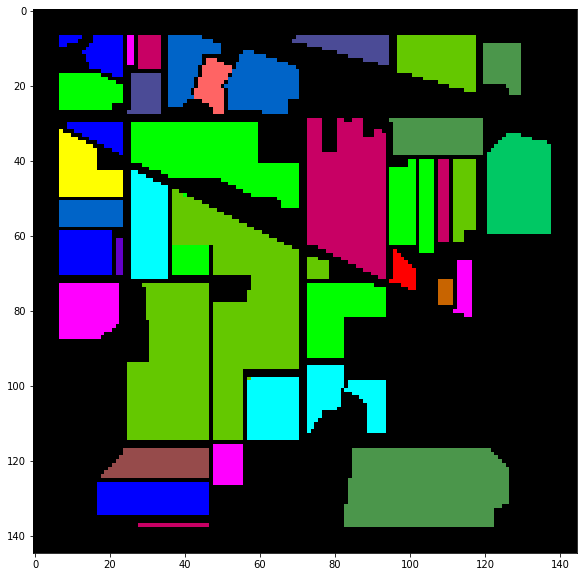

In [ ]:
predict_image =imshow(classes = outputs.astype(int),figsize =(10,10))